In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [75]:
# pandas로 데이터 불러오기

train_df = pd.read_csv('./dataset/digit-recognizer/train.csv')
test_df = pd.read_csv('./dataset/digit-recognizer/test.csv')


# shape 확인

print('train_df.shape =', train_df.shape)
print('test_df.shape =', test_df.shape)

train_df.shape = (42000, 785)
test_df.shape = (28000, 784)


In [3]:
# 데이터 프레임 확인

train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# train data 정답과 이미지 분리
# data frame을 numpy array로 변환

y = train_df.iloc[:,0]
x = train_df.iloc[:,1:]

y = np.array(y)
x = np.array(x)

In [6]:
# train data와 validation data를 8:2 비율로 나누기

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=36)

# train data 개수와 val data 개수 확인

print('length of x_train :', len(x_train))
print('length of x_val :', len(x_val))

length of x_train : 33600
length of x_val : 8400


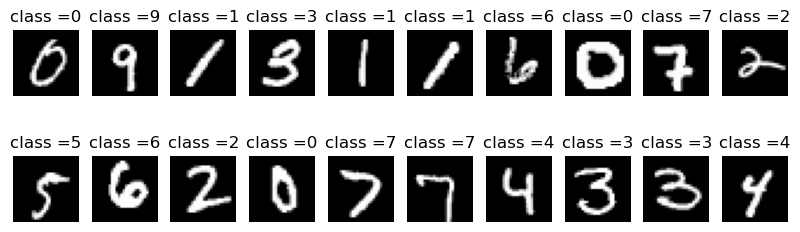

In [10]:
# x_train data 20개 시각화 및 y_train과 일치 여부 확인

import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.title('class ='+str(y_train[i]))

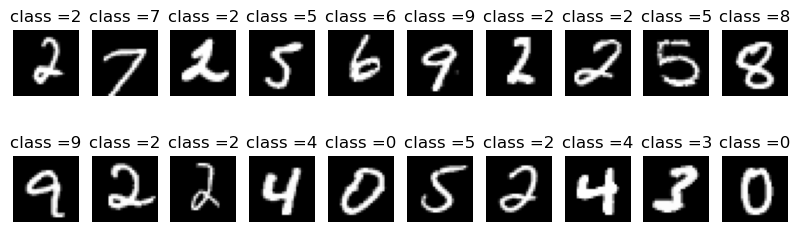

In [11]:
# x_val data 20개 시각화 및 y_val과 일치 여부 확인

import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.axis('off')
    plt.imshow(x_val[i].reshape(28,28), cmap='gray')
    plt.title('class ='+str(y_val[i]))

In [12]:
# x_train, x_val shape을 28 * 28에 1채널(흑백)으로 변경

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

# shape 확인

print('x_train.shape :',x_train.shape)
print('x_val.shape :',x_val.shape)

x_train.shape : (33600, 28, 28, 1)
x_val.shape : (8400, 28, 28, 1)


In [19]:
# data_set 만들기 class 정의

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch


class MNIST_dataset(Dataset):
    def __init__(self, img, cls, transforms=None):
        self.img = img
        self.cls = cls
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        img = self.img[idx].astype('uint8')
        cls = self.cls[idx]
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, cls
    
    def __len__(self):
        return self.img.shape[0]
    

In [21]:
# 데이터 변형 설정

transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(20, fill=0) # train data는 랜덤하게 20도 이하를 뒤틀어줌. 튀틀리고 빈공간은 검은색으로 채움.
])

transforms_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28))
])

In [22]:
# 데이터 셋과 데이터로더 정의

train_dataset = MNIST_dataset(img=x_train, 
                             cls=y_train, 
                             transforms=transforms_train)
val_dataset = MNIST_dataset(img=x_val, 
                           cls=y_val, 
                           transforms=transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=32, 
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=32,
                                             shuffle=False
                                            )

In [25]:
# MLP(Multi Layer Perceptron) model

class MLP_model(nn.Module):
    def __init__(self):
        super(MLP_model, self).__init__()
        self.fc1 = nn.Linear(28*28,512) # 이미지를 1줄로 flatten시켜서 fully connected layer로 변경
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28) # (28*28)의 2차원 백터를 1차원 백터로 flatten시킴
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [83]:
# device 설정, 노트북에 gpu가 없어서 cpu로 학습 진행 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cpu


In [30]:
# 경사 하강 방법 설정 및 손실 함수 정의

model = MLP_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

MLP_model(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [40]:
# train 함수 정의

def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (img, cls) in enumerate(train_loader):
        img = img.to(device)
        cls = cls.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, cls)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('train epoch : {} [{}/{} ({:.0f}%)] \t Train Loss : {:.6f}'.format(epoch, batch_idx*len(img),
                                                                                    len(train_loader.dataset), 
                                                                                     100. * batch_idx / len(train_loader),
                                                                                    loss.item()))

In [41]:
# validation 함수 정의

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img, cls in test_loader:
            img = img.to(device)
            cls = cls.to(device)
            output = model(img)
            test_loss += criterion(output, cls).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(cls.view_as(prediction)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

In [42]:
# 학습 진행

epochs = 100
for epoch in range(1, epochs + 1):
    train(model, train_dataloader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, val_dataloader)
    print('\n[epoch : {}], \t Test Loss : {:4f}, \t Test Accuracy : {:.2f}% \n'.format(epoch, test_loss, test_accuracy))

/Users/iseung-won/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train epoch : 1 [0/33600 (0%)] 	 Train Loss : 2.333536
train epoch : 1 [6400/33600 (19%)] 	 Train Loss : 2.327202
train epoch : 1 [12800/33600 (38%)] 	 Train Loss : 2.310938
train epoch : 1 [19200/33600 (57%)] 	 Train Loss : 2.293831
train epoch : 1 [25600/33600 (76%)] 	 Train Loss : 2.293139
train epoch : 1 [32000/33600 (95%)] 	 Train Loss : 2.294021

[epoch : 1], 	 Test Loss : 0.071863, 	 Test Accuracy : 9.86% 

train epoch : 2 [0/33600 (0%)] 	 Train Loss : 2.289397
train epoch : 2 [6400/33600 (19%)] 	 Train Loss : 2.287064
train epoch : 2 [12800/33600 (38%)] 	 Train Loss : 2.329977
train epoch : 2 [19200/33600 (57%)] 	 Train Loss : 2.293283
train epoch : 2 [25600/33600 (76%)] 	 Train Loss : 2.281112
train epoch : 2 [32000/33600 (95%)] 	 Train Loss : 2.277227

[epoch : 2], 	 Test Loss : 0.071366, 	 Test Accuracy : 16.10% 

train epoch : 3 [0/33600 (0%)] 	 Train Loss : 2.256752
train epoch : 3 [6400/33600 (19%)] 	 Train Loss : 2.229091
train epoch : 3 [12800/33600 (38%)] 	 Train Loss 

train epoch : 20 [19200/33600 (57%)] 	 Train Loss : 0.378515
train epoch : 20 [25600/33600 (76%)] 	 Train Loss : 0.302121
train epoch : 20 [32000/33600 (95%)] 	 Train Loss : 0.715188

[epoch : 20], 	 Test Loss : 0.014581, 	 Test Accuracy : 86.95% 

train epoch : 21 [0/33600 (0%)] 	 Train Loss : 0.326588
train epoch : 21 [6400/33600 (19%)] 	 Train Loss : 0.919514
train epoch : 21 [12800/33600 (38%)] 	 Train Loss : 0.832708
train epoch : 21 [19200/33600 (57%)] 	 Train Loss : 0.331690
train epoch : 21 [25600/33600 (76%)] 	 Train Loss : 0.481101
train epoch : 21 [32000/33600 (95%)] 	 Train Loss : 0.583353

[epoch : 21], 	 Test Loss : 0.014196, 	 Test Accuracy : 86.93% 

train epoch : 22 [0/33600 (0%)] 	 Train Loss : 0.600185
train epoch : 22 [6400/33600 (19%)] 	 Train Loss : 0.383561
train epoch : 22 [12800/33600 (38%)] 	 Train Loss : 0.482139
train epoch : 22 [19200/33600 (57%)] 	 Train Loss : 0.567035
train epoch : 22 [25600/33600 (76%)] 	 Train Loss : 0.354392
train epoch : 22 [32000/33

train epoch : 39 [32000/33600 (95%)] 	 Train Loss : 0.645657

[epoch : 39], 	 Test Loss : 0.011407, 	 Test Accuracy : 89.55% 

train epoch : 40 [0/33600 (0%)] 	 Train Loss : 0.447260
train epoch : 40 [6400/33600 (19%)] 	 Train Loss : 0.719840
train epoch : 40 [12800/33600 (38%)] 	 Train Loss : 0.395510
train epoch : 40 [19200/33600 (57%)] 	 Train Loss : 0.291188
train epoch : 40 [25600/33600 (76%)] 	 Train Loss : 0.423062
train epoch : 40 [32000/33600 (95%)] 	 Train Loss : 0.492277

[epoch : 40], 	 Test Loss : 0.011527, 	 Test Accuracy : 89.58% 

train epoch : 41 [0/33600 (0%)] 	 Train Loss : 0.318687
train epoch : 41 [6400/33600 (19%)] 	 Train Loss : 0.579135
train epoch : 41 [12800/33600 (38%)] 	 Train Loss : 0.268377
train epoch : 41 [19200/33600 (57%)] 	 Train Loss : 0.341369
train epoch : 41 [25600/33600 (76%)] 	 Train Loss : 0.290596
train epoch : 41 [32000/33600 (95%)] 	 Train Loss : 0.269337

[epoch : 41], 	 Test Loss : 0.011316, 	 Test Accuracy : 89.75% 

train epoch : 42 [0/3

train epoch : 59 [6400/33600 (19%)] 	 Train Loss : 0.245379
train epoch : 59 [12800/33600 (38%)] 	 Train Loss : 0.488816
train epoch : 59 [19200/33600 (57%)] 	 Train Loss : 0.499555
train epoch : 59 [25600/33600 (76%)] 	 Train Loss : 0.680422
train epoch : 59 [32000/33600 (95%)] 	 Train Loss : 0.346835

[epoch : 59], 	 Test Loss : 0.010137, 	 Test Accuracy : 90.99% 

train epoch : 60 [0/33600 (0%)] 	 Train Loss : 0.533843
train epoch : 60 [6400/33600 (19%)] 	 Train Loss : 0.212314
train epoch : 60 [12800/33600 (38%)] 	 Train Loss : 0.404694
train epoch : 60 [19200/33600 (57%)] 	 Train Loss : 0.339392
train epoch : 60 [25600/33600 (76%)] 	 Train Loss : 0.300397
train epoch : 60 [32000/33600 (95%)] 	 Train Loss : 0.435130

[epoch : 60], 	 Test Loss : 0.010079, 	 Test Accuracy : 91.02% 

train epoch : 61 [0/33600 (0%)] 	 Train Loss : 0.333727
train epoch : 61 [6400/33600 (19%)] 	 Train Loss : 0.348020
train epoch : 61 [12800/33600 (38%)] 	 Train Loss : 0.579778
train epoch : 61 [19200/336

train epoch : 78 [19200/33600 (57%)] 	 Train Loss : 0.555496
train epoch : 78 [25600/33600 (76%)] 	 Train Loss : 0.272037
train epoch : 78 [32000/33600 (95%)] 	 Train Loss : 0.569201

[epoch : 78], 	 Test Loss : 0.009058, 	 Test Accuracy : 92.02% 

train epoch : 79 [0/33600 (0%)] 	 Train Loss : 0.194295
train epoch : 79 [6400/33600 (19%)] 	 Train Loss : 0.260879
train epoch : 79 [12800/33600 (38%)] 	 Train Loss : 0.366127
train epoch : 79 [19200/33600 (57%)] 	 Train Loss : 0.292758
train epoch : 79 [25600/33600 (76%)] 	 Train Loss : 0.337064
train epoch : 79 [32000/33600 (95%)] 	 Train Loss : 0.631301

[epoch : 79], 	 Test Loss : 0.008943, 	 Test Accuracy : 92.08% 

train epoch : 80 [0/33600 (0%)] 	 Train Loss : 0.289180
train epoch : 80 [6400/33600 (19%)] 	 Train Loss : 0.285284
train epoch : 80 [12800/33600 (38%)] 	 Train Loss : 0.514897
train epoch : 80 [19200/33600 (57%)] 	 Train Loss : 0.199107
train epoch : 80 [25600/33600 (76%)] 	 Train Loss : 0.826964
train epoch : 80 [32000/33

train epoch : 97 [32000/33600 (95%)] 	 Train Loss : 0.267208

[epoch : 97], 	 Test Loss : 0.008008, 	 Test Accuracy : 92.73% 

train epoch : 98 [0/33600 (0%)] 	 Train Loss : 0.211844
train epoch : 98 [6400/33600 (19%)] 	 Train Loss : 0.424138
train epoch : 98 [12800/33600 (38%)] 	 Train Loss : 0.336632
train epoch : 98 [19200/33600 (57%)] 	 Train Loss : 0.324548
train epoch : 98 [25600/33600 (76%)] 	 Train Loss : 0.195794
train epoch : 98 [32000/33600 (95%)] 	 Train Loss : 0.557823

[epoch : 98], 	 Test Loss : 0.008033, 	 Test Accuracy : 92.60% 

train epoch : 99 [0/33600 (0%)] 	 Train Loss : 0.268144
train epoch : 99 [6400/33600 (19%)] 	 Train Loss : 0.289142
train epoch : 99 [12800/33600 (38%)] 	 Train Loss : 0.356195
train epoch : 99 [19200/33600 (57%)] 	 Train Loss : 0.105097
train epoch : 99 [25600/33600 (76%)] 	 Train Loss : 0.556726
train epoch : 99 [32000/33600 (95%)] 	 Train Loss : 0.585960

[epoch : 99], 	 Test Loss : 0.007925, 	 Test Accuracy : 92.74% 

train epoch : 100 [0/

(28000, 28, 28, 1)


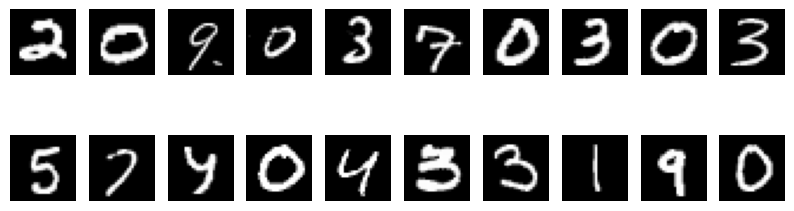

In [76]:
# test 데이터 numpy arrayfh 변환 및 시각화

x_test = np.array(test_df).reshape(-1,28,28,1)
print(x_test.shape)

plt.figure(figsize=(10,3))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.axis('off')
    plt.imshow(x_test[i], cmap='gray')

In [77]:
# 데이터 셋을 맞추기 위해 cls column 추가

test_df['cls'] = 0
test_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,cls
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# 이미지, 정답 분리 및 numpy array로 변환, reshape

x_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]

x_test = np.array(x_test)
x_test = x_test.reshape(-1, 28,28,1)

In [80]:
# dataset 및 dataloader 정의

test_dataset = MNIST_dataset(img=x_test, cls=y_test, transforms=transforms_val)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [81]:
# 예측

final_preds = []

def predict(model, dataloader, device):
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().data.numpy()
            
            final_preds.extend(preds)
            
predict(model, test_dataloader, device)

print(len(final_preds))
print(final_preds)

/Users/iseung-won/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


28000
[2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 9, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 5, 9, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 3, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 3, 2, 0, 7, 3, 0, 5, 0, 3, 0, 0, 4, 7, 1, 7, 1, 1, 5, 3, 3, 7, 2, 8, 6, 3, 8, 7, 8, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 2, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 3, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 7, 2, 1, 6, 3, 4, 2, 3, 1, 2, 2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 2, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 8, 9, 7, 1, 3, 8, 4, 5, 1, 4, 3, 6, 3, 3, 5, 7, 0, 6, 8, 6, 1, 6, 0, 6, 3, 9, 9, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 8, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 6, 3, 7, 1, 4, 5, 8, 6, 4, 0, 0, 3, 8, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 5, 3, 6, 

In [62]:
submission = pd.read_csv('./dataset/digit-recognizer/sample_submission.csv')
submission['Label'] = final_preds
submission.to_csv('./dataset/digit-recognizer/submission.csv', index=False)
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


(-0.5, 963.5, 188.5, -0.5)

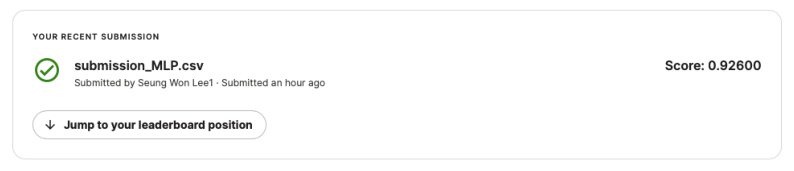

In [72]:
import cv2
score = cv2.imread('./dataset/digit-recognizer/MLP.png')
plt.figure(figsize=(10,2))
plt.imshow(score, cmap='gray')
plt.axis('off')